A1:
[[ 24.94003847  12.73268299  -1.38095598 ... -64.02389647 -67.76356741
  -61.18058974]
 [-18.55666362 -42.51586944 -60.80795253 ... -26.39439597   6.86544434
   41.4436393 ]
 [-16.04755868 -22.03971648 -23.23089505 ... -25.03391682 -29.2936105
  -31.3712619 ]
 ...
 [ 24.73021466  34.94179045  38.82924248 ...   4.99619196  -9.93322885
  -25.6299042 ]
 [ 25.33720124  43.00958768  51.93221654 ... -30.76392977 -58.45411318
  -74.0191717 ]
 [ -6.4753501   15.86720969  37.73898369 ...  37.9440317    8.26766066
  -26.92595056]]


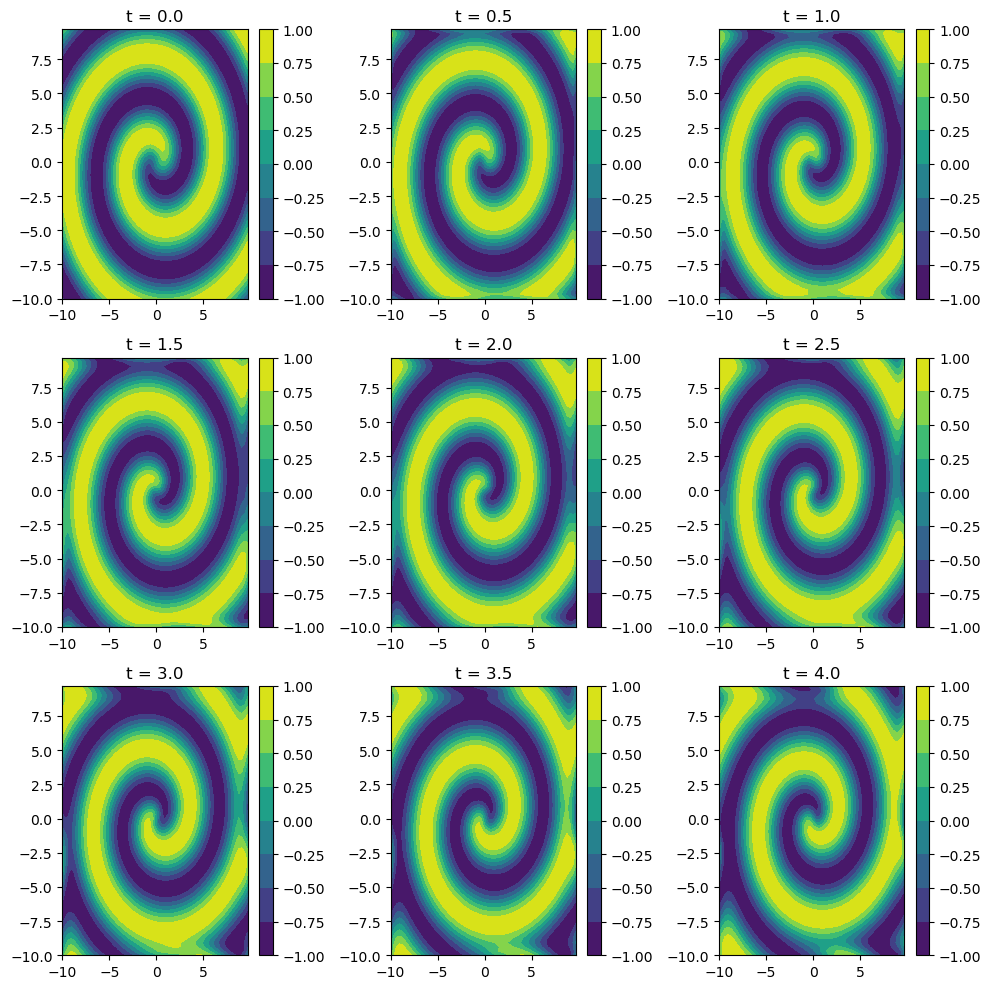

In [5]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
L = 20
m = 1
beta = 1
D1 = 0.1
D2 = 0.1
tspan = (0, 4)
time_eval = np.arange(0, 4.5, 0.5)

# FFT Initialization for Periodic Boundaries
def initialize_uvf(X, Y, m, n):
    u0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
    v0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
    uf0 = fft2(u0).reshape(n**2, 1)
    vf0 = fft2(v0).reshape(n**2, 1)
    return np.concatenate((uf0.flatten(), vf0.flatten()))

n = 64
xy = np.linspace(-L/2, L/2, n + 1)[:-1]
X, Y = np.meshgrid(xy, xy)
kxy = (2 * np.pi / L) * np.concatenate((np.arange(0, n//2), np.arange(-n//2, 0)))
KX, KY = np.meshgrid(kxy, kxy)
K = KX**2 + KY**2
fftLap = -K
uvf0_vec = initialize_uvf(X, Y, m, n)

# FFT Right-Hand Side
def fft_rhs(t, uvf_vec, n, Lap, D1, D2, beta):
    uf_vec = uvf_vec[:n**2]
    vf_vec = uvf_vec[n**2:]
    uf = uf_vec.reshape(n, n)
    vf = vf_vec.reshape(n, n)
    u = np.real(ifft2(uf))
    v = np.real(ifft2(vf))
    u_vec = u.flatten()
    v_vec = v.flatten()
    A_vec = u_vec**2 + v_vec**2
    lambda_vec = 1 - A_vec
    omega_vec = -beta * A_vec
    utLpart_vec = lambda_vec * u_vec - omega_vec * v_vec
    vtLpart_vec = omega_vec * u_vec + lambda_vec * v_vec
    utfLpart = fft2(utLpart_vec.reshape(n, n))
    vtfLpart = fft2(vtLpart_vec.reshape(n, n))
    uft = utfLpart + D1 * Lap * uf
    vft = vtfLpart + D2 * Lap * vf
    return np.concatenate((uft.flatten(), vft.flatten()))

# Solve FFT System
sol_fft = solve_ivp(
    lambda t, uvf_vec: fft_rhs(t, uvf_vec, n, fftLap, D1, D2, beta),
    tspan, uvf0_vec, t_eval=time_eval
)
A1 = np.real(sol_fft.y)
print("A1:")
print(A1)

plt.figure(figsize=(10, 10))
for j, t in enumerate(time_eval):
    u_fft = sol_fft.y[:n**2, j].reshape(n, n)
    u_real = np.real(ifft2(u_fft))
    
    plt.subplot(3, 3, j + 1)
    plt.contourf(X, Y, u_real)
    plt.colorbar()
    plt.title(f"t = {t:.1f}")

plt.tight_layout()
plt.show()

A2:
[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]


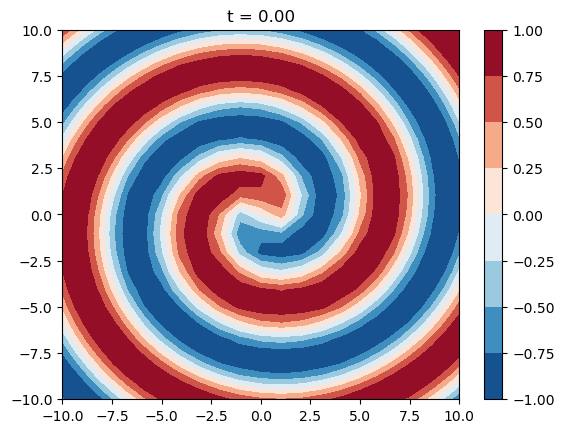

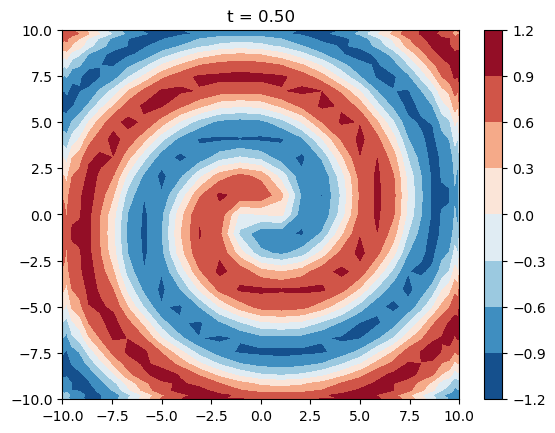

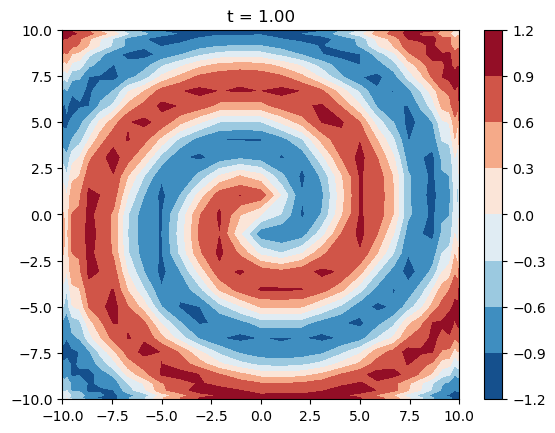

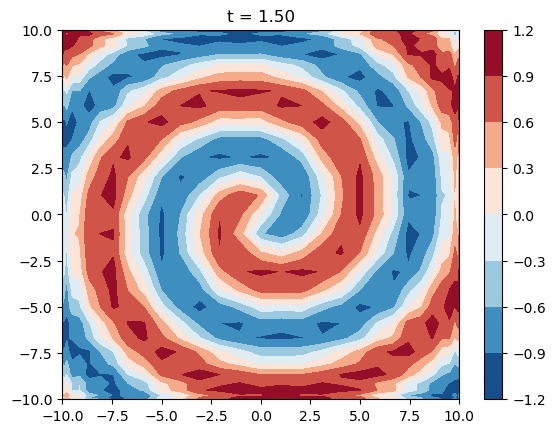

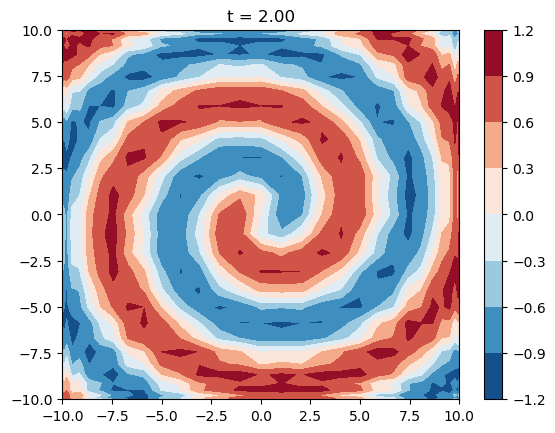

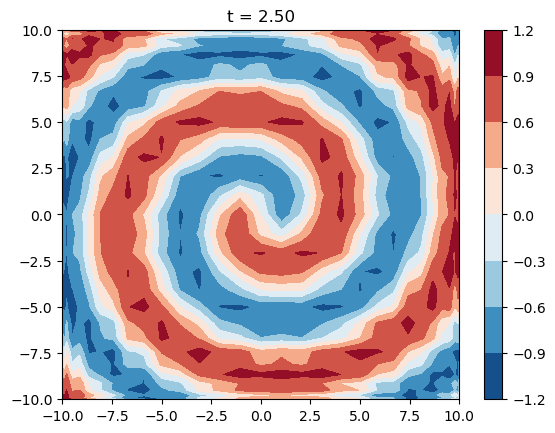

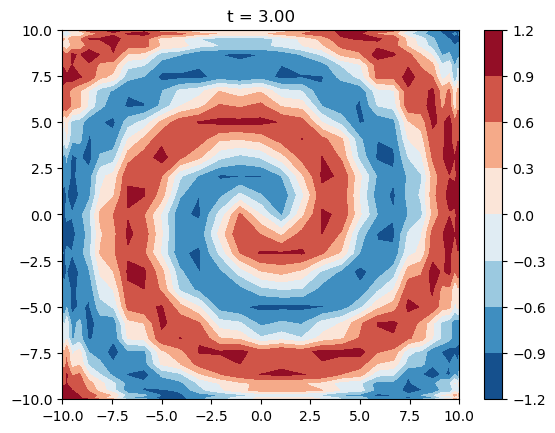

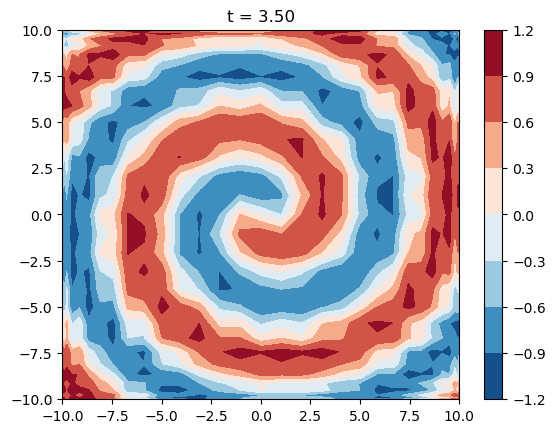

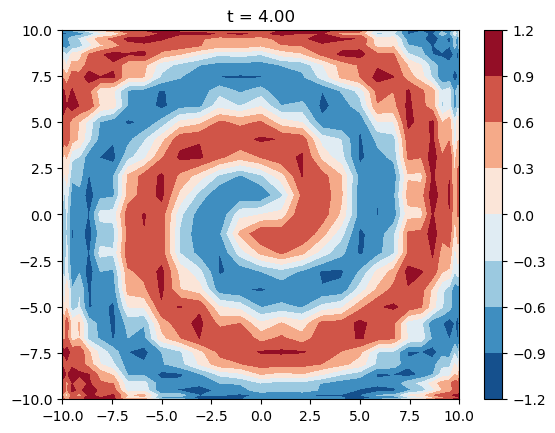

In [24]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import kron

def cheb(N):
    if N == 0:
        return np.array([[0]]), np.array([1])
    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.concatenate([[2], np.ones(N - 1), [2]]) * (-1)**np.arange(N + 1)
    X = np.tile(x, (N + 1, 1))
    dX = X - X.T
    D = (c[:, None] / c[None, :]) / (dX + np.eye(N + 1))
    D -= np.diag(np.sum(D, axis=1))
    return D, x

N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = np.dot(D, D) / ((20 / 2)**2)
y = x
N2 = (N + 1) * (N + 1)

I = np.eye(len(Dxx))
L = kron(I, Dxx) + kron(Dxx, I)

X, Y = np.meshgrid(x, y)
X = X * (20 / 2)
Y = Y * (20 / 2)

m = 1
U0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
uv0_vec = np.hstack([U0.flatten(), V0.flatten()])

def cheb_rhs(t, uv_vec, L, D1, D2, beta, N2):
    u_vec = uv_vec[:N2]
    v_vec = uv_vec[N2:]
    
    A_vec = u_vec**2 + v_vec**2
    lambda_vec = 1 - A_vec
    omega_vec = -beta * A_vec
    
    rhs_u = D1 * np.dot(L, u_vec) + lambda_vec * u_vec - omega_vec * v_vec
    rhs_v = D2 * np.dot(L, v_vec) + omega_vec * u_vec + lambda_vec * v_vec
    
    rhs = np.hstack([rhs_u, rhs_v])
    return rhs

D1 = 0.1
D2 = 0.1
beta = 1
tspan = (0, 4)
time_eval = np.linspace(0, 4, 9)

sol_cheb = solve_ivp(
    lambda t, uv_vec: cheb_rhs(t, uv_vec, L, D1, D2, beta, N2),
    tspan, uv0_vec, t_eval=time_eval, method='RK45'
)

A2 = sol_cheb.y
print("A2:")
print(A2)

import matplotlib.pyplot as plt

for j, t in enumerate(time_eval):
    u_sol = sol_cheb.y[:N2, j].reshape(N + 1, N + 1)
    plt.contourf(X, Y, u_sol, cmap="RdBu_r")
    plt.colorbar()
    plt.title(f"t = {t:.2f}")
    plt.show()